In [16]:
# %%
# =========================================
# 0. Imports
# =========================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from catboost import CatBoostClassifier, CatBoostRanker, Pool

plt.rcParams["figure.figsize"] = (8, 5)

In [17]:
# %%
# =========================================
# 1. Load CSV and basic cleaning
# =========================================

df = pd.read_csv("export.csv")
print("Initial rows:", len(df))

# market caps must be positive
df = df[(df["stock_market_cap"] > 0) & (df["future_market_cap_6m"] > 0)]
print("Rows after cleaning market caps:", len(df))

# dates
df["ttm_date"] = pd.to_datetime(df["ttm_date"])
df["daily_date"] = pd.to_datetime(df["daily_date"])
df["target_date"] = pd.to_datetime(df["target_date"])
df["daily_target_date"] = pd.to_datetime(df["daily_target_date"])

# quarter for ranking
df["year_quarter"] = (
    df["ttm_date"].dt.year.astype(str)
    + "_Q"
    + ((df["ttm_date"].dt.month - 1) // 3 + 1).astype(str)
)

# sort for time-based features
df = df.sort_values(["stock_name", "ttm_date"])

Initial rows: 250228
Rows after cleaning market caps: 235252


In [18]:
# %%
# =========================================
# 2. 6-month return и НОВЫЙ таргет (>10%)
# =========================================

df["return_6m"] = df["future_market_cap_6m"] / df["stock_market_cap"] - 1

# trim 1–99% quantiles
low_q, high_q = df["return_6m"].quantile([0.01, 0.99])
df = df[(df["return_6m"] >= low_q) & (df["return_6m"] <= high_q)]
print("Rows after return trimming:", len(df))

df["target"] = (df["return_6m"] > 0.10).astype(int)

print("Target distribution (proportion):")
print(df["target"].value_counts(normalize=True).rename("proportion"))

Rows after return trimming: 230546
Target distribution (proportion):
target
0    0.613561
1    0.386439
Name: proportion, dtype: float64


In [19]:
# %%
# =========================================
# 3. Clips on fundamentals/multipliers
# =========================================

def clip_range(col, low, high):
    if col in df.columns:
        df[col] = df[col].clip(lower=low, upper=high)

# margins / profitability
clip_range("gross_margin", -20, 90)
clip_range("ebit_margin", -20, 60)
clip_range("ebitda_margin", -20, 60)
clip_range("net_profit_margin", -50, 40)
clip_range("roce", -50, 60)
clip_range("roic", -50, 60)

# valuation ratios
clip_range("price_to_book_ratio", 0, 20)
clip_range("price_to_earnings_ratio", -20, 80)
clip_range("ev_fcf_ratio", -20, 80)
clip_range("price_to_sales_ratio", 0, 20)

df["log_mcap"] = np.log1p(df["stock_market_cap"])

In [20]:
# %%
# =========================================
# 4. Lags, deltas, percentage deltas, rolling features
# =========================================

base_series_cols = [
    "eps",
    "free_cash_flow",
    "gross_margin",
    "net_profit_margin",
    "total_debt",
    "total_equity",
    "ebit_margin",
    "ebitda_margin",
]

base_series_cols = [c for c in base_series_cols if c in df.columns]

lag_features = []
delta_features = []
delta_pct_features = []
rolling_features = []

# lags and deltas
for col in base_series_cols:
    lag1 = f"{col}_lag1"
    lag2 = f"{col}_lag2"

    df[lag1] = df.groupby("stock_name")[col].shift(1)
    df[lag2] = df.groupby("stock_name")[col].shift(2)

    lag_features.extend([lag1, lag2])

    delta = f"{col}_delta"
    df[delta] = df[col] - df[lag1]
    delta_features.append(delta)

    delta_pct = f"{col}_delta_pct"
    df[delta_pct] = df[delta] / (df[lag1].abs() + 1e-6)
    delta_pct_features.append(delta_pct)

# rolling for 3 latest TTM
rolling_base_cols = [
    c for c in ["eps", "free_cash_flow", "gross_margin", "net_profit_margin"]
    if c in df.columns
]

for col in rolling_base_cols:
    roll_mean = f"{col}_roll_mean3"
    roll_std = f"{col}_roll_std3"

    grp = df.groupby("stock_name")[col]
    df[roll_mean] = grp.transform(lambda x: x.rolling(3, min_periods=1).mean())
    df[roll_std] = grp.transform(lambda x: x.rolling(3, min_periods=1).std()).fillna(0.0)

    rolling_features.extend([roll_mean, roll_std])

print("Lag features:", lag_features[:6], "...")
print("Delta features:", delta_features[:6], "...")
print("Delta pct features:", delta_pct_features[:6], "...")
print("Rolling features:", rolling_features[:6], "...")

Lag features: ['eps_lag1', 'eps_lag2', 'free_cash_flow_lag1', 'free_cash_flow_lag2', 'gross_margin_lag1', 'gross_margin_lag2'] ...
Delta features: ['eps_delta', 'free_cash_flow_delta', 'gross_margin_delta', 'net_profit_margin_delta', 'total_debt_delta', 'total_equity_delta'] ...
Delta pct features: ['eps_delta_pct', 'free_cash_flow_delta_pct', 'gross_margin_delta_pct', 'net_profit_margin_delta_pct', 'total_debt_delta_pct', 'total_equity_delta_pct'] ...
Rolling features: ['eps_roll_mean3', 'eps_roll_std3', 'free_cash_flow_roll_mean3', 'free_cash_flow_roll_std3', 'gross_margin_roll_mean3', 'gross_margin_roll_std3'] ...


In [21]:
# %%
# =========================================
# 5. Ratio-features
# =========================================

if {"total_debt", "total_equity"}.issubset(df.columns):
    df["debt_to_equity"] = df["total_debt"] / (df["total_equity"].abs() + 1e-6)
else:
    df["debt_to_equity"] = np.nan

if {"free_cash_flow", "stock_market_cap"}.issubset(df.columns):
    df["fcf_yield"] = df["free_cash_flow"] / (df["stock_market_cap"].abs() + 1e-6)
else:
    df["fcf_yield"] = np.nan

if {"capital_expenditures", "free_cash_flow"}.issubset(df.columns):
    df["capex_to_fcf"] = df["capital_expenditures"] / (df["free_cash_flow"].abs() + 1e-6)
else:
    df["capex_to_fcf"] = np.nan

ratio_features = ["debt_to_equity", "fcf_yield", "capex_to_fcf"]

In [22]:
# %%
# =========================================
# 6. Removing the noisiest growth columns
# =========================================

drop_cols = [
    "eps_fully_diluted",
    "growth_rate",
    "earnings_growth",
    "ebitda_growth",
    "net_income_growth",
]

for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=c)

In [23]:
# %%
# =========================================
# 7. Time-based split
# =========================================

train = df[df["ttm_date"] <= "2016-12-31"].copy()
val   = df[(df["ttm_date"] > "2016-12-31") & (df["ttm_date"] <= "2019-12-31")].copy()
test  = df[df["ttm_date"] > "2019-12-31"].copy()

print("Train:", len(train), "Val:", len(val), "Test:", len(test))

train = train.dropna(subset=["target"])
val   = val.dropna(subset=["target"])
test  = test.dropna(subset=["target"])

# group_id for ranking
train["group_id"] = train["year_quarter"]
val["group_id"]   = val["year_quarter"]
test["group_id"]  = test["year_quarter"]

Train: 103167 Val: 38039 Test: 89340


In [24]:
# %%
# =========================================
# 8. Feature lists
# =========================================

base_numeric = [
    "stock_market_cap", "log_mcap",
    "gross_margin", "ebit_margin", "ebitda_margin",
    "net_profit_margin", "roce", "roic",
    "fcf_per_share_growth", "free_cash_flow_growth",
    "operating_income", "eps", "free_cash_flow",
    "total_debt", "total_equity", "net_operating_cash_flow",
    "capital_expenditures", "cash_equivalents", "shares_outstanding",
    "price_to_sales_ratio", "ev_fcf_ratio",
    "price_to_earnings_ratio", "price_to_book_ratio", "ev_sales",
]

base_numeric = [c for c in base_numeric if c in df.columns]

num_features = (
    base_numeric
    + lag_features
    + delta_features
    + delta_pct_features
    + rolling_features
    + ratio_features
)

num_features = [c for c in num_features if c in df.columns]

cat_features = ["sector", "country_code"]
for c in cat_features:
    if c not in df.columns:
        df[c] = "Unknown"

all_features = num_features + cat_features

print("Numeric features:", len(num_features))
print("Categorical features:", cat_features)

for c in cat_features:
    train[c] = train[c].fillna("Unknown")
    val[c] = val[c].fillna("Unknown")
    test[c] = test[c].fillna("Unknown")

Numeric features: 67
Categorical features: ['sector', 'country_code']


In [25]:
# %%
# =========================================
# 9. Filter by the number of numeric NaNs
# =========================================

min_non_null = int(0.7 * len(num_features))

def filter_by_missing(frame):
    mask = frame[num_features].notnull().sum(axis=1) >= min_non_null
    return frame[mask]

train = filter_by_missing(train)
val   = filter_by_missing(val)
test  = filter_by_missing(test)

print("After missing-filter:")
print("Train:", len(train), "Val:", len(val), "Test:", len(test))

After missing-filter:
Train: 85843 Val: 32109 Test: 75662


In [26]:
# =========================================
# 9.1. Drop features with too many missing values (>30%)
# =========================================

missing_ratio = df[num_features].isnull().mean()
high_missing_feats = missing_ratio[missing_ratio > 0.30].index.tolist()

print("Dropping features with >30% missing:")
print(high_missing_feats)

num_features = [f for f in num_features if f not in high_missing_feats]
all_features = num_features + cat_features

Dropping features with >30% missing:
['roic']


In [27]:
# %% 
# 10. Preparing CatBoost Pools for Classification

X_train = train[all_features]
y_train = train["target"]

X_val = val[all_features]
y_val = val["target"]

X_test = test[all_features]
y_test = test["target"]

cat_cols = cat_features

train_pool = Pool(X_train, label=y_train, cat_features=cat_cols)
val_pool   = Pool(X_val, label=y_val, cat_features=cat_cols)
test_pool  = Pool(X_test, label=y_test, cat_features=cat_cols)

pos_rate = y_train.mean()
neg_rate = 1 - pos_rate
pos_weight = neg_rate / pos_rate
print(f"Positive rate: {pos_rate:.3f}, weight={pos_weight:.2f}")

Positive rate: 0.419, weight=1.39


In [28]:
# %%
# =========================================
# 11. CatBoost CLASSIFIER (hyper-search)
# =========================================

param_grid = [
    {"depth": 8,  "learning_rate": 0.05, "l2_leaf_reg": 3},
    {"depth": 8,  "learning_rate": 0.03, "l2_leaf_reg": 5},
    {"depth": 10, "learning_rate": 0.03, "l2_leaf_reg": 5},
    {"depth": 10, "learning_rate": 0.02, "l2_leaf_reg": 7},
    {"depth": 12, "learning_rate": 0.02, "l2_leaf_reg": 5},
]

best_auc = -np.inf
best_clf = None
best_params = None
best_clf_evals = None

for i, params in enumerate(param_grid, 1):
    print(f"\n=== Trial {i}/{len(param_grid)} — params: {params} ===")

    clf = CatBoostClassifier(
        iterations=3000,
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=42,
        verbose=100,
        class_weights=[1.0, pos_weight],
        od_type="Iter",
        od_wait=200,
        depth=params["depth"],
        learning_rate=params["learning_rate"],
        l2_leaf_reg=params["l2_leaf_reg"],
        bagging_temperature=0.3,
        random_strength=1.0,
        grow_policy="Lossguide",
    )

    clf.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        verbose=100,
    )

    best_score = clf.get_best_score()["validation"]["AUC"]
    print(f"Validation AUC for this model: {best_score:.6f}")

    if best_score > best_auc:
        best_auc = best_score
        best_clf = clf
        best_params = params
        best_clf_evals = clf.get_evals_result()

print("\nBest classifier params:", best_params)
print("Best validation AUC:", best_auc)

clf_model = best_clf
clf_evals_result = best_clf_evals


=== Trial 1/5 — params: {'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 3} ===
0:	test: 0.5463075	best: 0.5463075 (0)	total: 27.1ms	remaining: 1m 21s
100:	test: 0.5720254	best: 0.5720295 (95)	total: 2.88s	remaining: 1m 22s
200:	test: 0.5722874	best: 0.5725524 (157)	total: 5.45s	remaining: 1m 15s
300:	test: 0.5723892	best: 0.5729045 (209)	total: 8.15s	remaining: 1m 13s
400:	test: 0.5711921	best: 0.5729045 (209)	total: 11.3s	remaining: 1m 13s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.572904512
bestIteration = 209

Shrink model to first 210 iterations.
Validation AUC for this model: 0.572905

=== Trial 2/5 — params: {'depth': 8, 'learning_rate': 0.03, 'l2_leaf_reg': 5} ===
0:	test: 0.5460442	best: 0.5460442 (0)	total: 29.6ms	remaining: 1m 28s
100:	test: 0.5722158	best: 0.5725097 (83)	total: 2.72s	remaining: 1m 18s
200:	test: 0.5734320	best: 0.5735937 (152)	total: 5.09s	remaining: 1m 10s
300:	test: 0.5730359	best: 0.5735937 (152)	total: 7.64s	remaining: 1m 8s

Classifier Test ROC-AUC: 0.5851698884982836

Classifier report:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59     46925
           1       0.43      0.59      0.50     28737

    accuracy                           0.55     75662
   macro avg       0.55      0.56      0.54     75662
weighted avg       0.58      0.55      0.56     75662



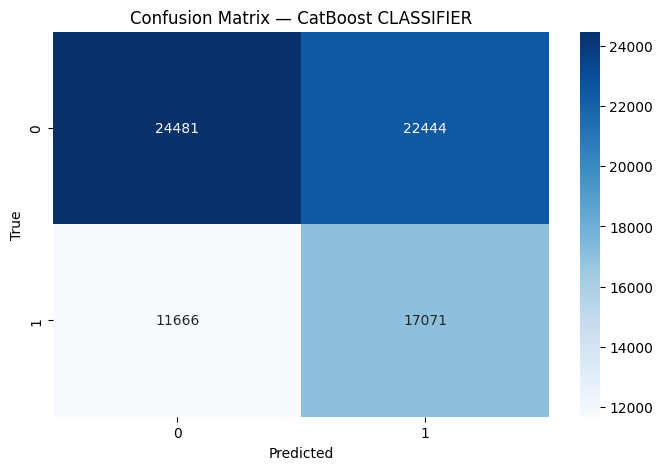

In [29]:
# %%
# =========================================
# 12. CLASSIFIER's score on the test
# =========================================

proba_test_clf = clf_model.predict_proba(test_pool)[:, 1]
pred_test_clf = (proba_test_clf >= 0.5).astype(int)

clf_auc = roc_auc_score(y_test, proba_test_clf)
print("Classifier Test ROC-AUC:", clf_auc)
print("\nClassifier report:")
print(classification_report(y_test, pred_test_clf))

cm_clf = confusion_matrix(y_test, pred_test_clf)
sns.heatmap(cm_clf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — CatBoost CLASSIFIER")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [30]:
# =========================================
# 12.1. BASELINE: Logistic Regression
# =========================================

X_train_lr = train[num_features]
X_test_lr  = test[num_features]

y_train_lr = train["target"]
y_test_lr  = test["target"]

lr_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

lr_pipeline.fit(X_train_lr, y_train_lr)

proba_lr = lr_pipeline.predict_proba(X_test_lr)[:, 1]
auc_lr = roc_auc_score(y_test_lr, proba_lr)

print("Logistic Regression Test ROC-AUC:", auc_lr)

Logistic Regression Test ROC-AUC: 0.5350651525290007



Top 20 features by importance (classifier):
fcf_yield                   7.519402
price_to_sales_ratio        4.959000
shares_outstanding          4.279026
total_equity_delta_pct      3.835755
eps_delta                   3.747323
free_cash_flow_delta_pct    3.551626
eps_delta_pct               3.112729
eps_lag1                    3.074409
eps                         2.932440
log_mcap                    2.928592
stock_market_cap            2.632480
eps_roll_mean3              2.541989
price_to_book_ratio         2.363219
free_cash_flow_delta        2.231429
ebitda_margin_delta         2.039410
ebitda_margin_delta_pct     2.019499
total_equity_delta          1.850151
price_to_earnings_ratio     1.832454
total_equity_lag2           1.697946
ebit_margin_delta           1.630241
dtype: float64


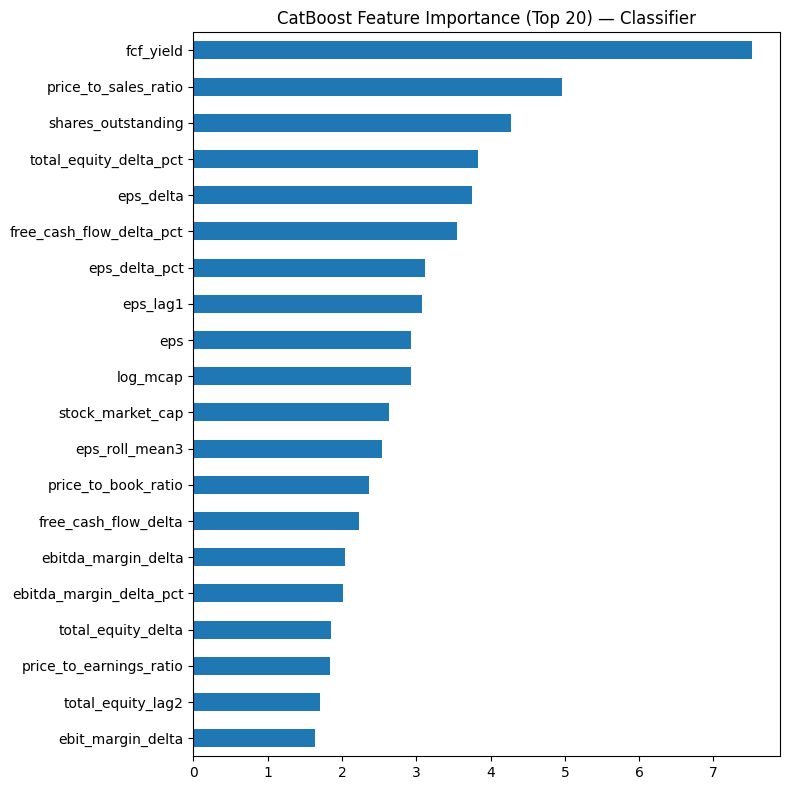

In [31]:
# %%
# =========================================
# 13. Feature importance (classifier)
# =========================================

importances = clf_model.get_feature_importance(train_pool)
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

print("\nTop 20 features by importance (classifier):")
print(feat_imp.head(20))

plt.figure(figsize=(8, 8))
feat_imp.head(20).sort_values().plot(kind="barh")
plt.title("CatBoost Feature Importance (Top 20) — Classifier")
plt.tight_layout()
plt.show()

In [32]:
# %% 
# 14. Preparing data for RANKER (mandatory sorting by group_id)

print("\n==============================")
print("TRAINING CATBOOST RANKER MODEL")
print("==============================\n")

# We sort it so that within each group_id all the rows are in a row
rank_train = train.sort_values(["group_id", "ttm_date", "stock_name"]).reset_index(drop=True)
rank_val   = val.sort_values(["group_id", "ttm_date", "stock_name"]).reset_index(drop=True)
rank_test  = test.sort_values(["group_id", "ttm_date", "stock_name"]).reset_index(drop=True)

rank_train_pool = Pool(
    rank_train[all_features],
    label=rank_train["return_6m"],
    group_id=rank_train["group_id"],
    cat_features=cat_cols,
)

rank_val_pool = Pool(
    rank_val[all_features],
    label=rank_val["return_6m"],
    group_id=rank_val["group_id"],
    cat_features=cat_cols,
)

rank_test_pool = Pool(
    rank_test[all_features],
    label=rank_test["return_6m"],
    group_id=rank_test["group_id"],
    cat_features=cat_cols,
)

ranker_model = CatBoostRanker(
    loss_function="YetiRank",
    eval_metric="NDCG:top=10",
    iterations=1500,
    learning_rate=0.03,
    depth=8,
    verbose=100,
    random_seed=42,
)

ranker_model.fit(
    rank_train_pool,
    eval_set=rank_val_pool,
    use_best_model=True,
    verbose=100,
)

rank_evals_result = ranker_model.get_evals_result()


TRAINING CATBOOST RANKER MODEL

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.0039399	best: 0.0039399 (0)	total: 246ms	remaining: 6m 8s
100:	test: 0.2130983	best: 0.2228712 (98)	total: 19.9s	remaining: 4m 35s
200:	test: 0.1796301	best: 0.2228712 (98)	total: 38.6s	remaining: 4m 9s
300:	test: 0.1667843	best: 0.2228712 (98)	total: 58.7s	remaining: 3m 53s
400:	test: 0.1518053	best: 0.2228712 (98)	total: 1m 16s	remaining: 3m 30s
500:	test: 0.1470058	best: 0.2228712 (98)	total: 1m 35s	remaining: 3m 9s
600:	test: 0.1273175	best: 0.2228712 (98)	total: 1m 54s	remaining: 2m 51s
700:	test: 0.1268859	best: 0.2228712 (98)	total: 2m 16s	remaining: 2m 35s
800:	test: 0.1302028	best: 0.2228712 (98)	total: 2m 36s	remaining: 2m 16s
900:	test: 0.1326876	best: 0.2228712 (98)	total: 2m 58s	remaining: 1m 58s
1000:	test: 0.1241674	best: 0.2228712 (98)	total: 3m 18s	remaining: 1m 39s
1100:	test: 0.1291914	best: 0.2228712 (98)	total: 3m 38s	remaining: 1m 19s
1200:	test: 0.1187888	best: 0.2228712 


Ranker ROC-AUC vs binary target (>10%): 0.5670077671868083

Ranker classification report (threshold=median):
              precision    recall  f1-score   support

           0       0.66      0.54      0.59     46925
           1       0.42      0.56      0.48     28737

    accuracy                           0.54     75662
   macro avg       0.54      0.55      0.54     75662
weighted avg       0.57      0.54      0.55     75662



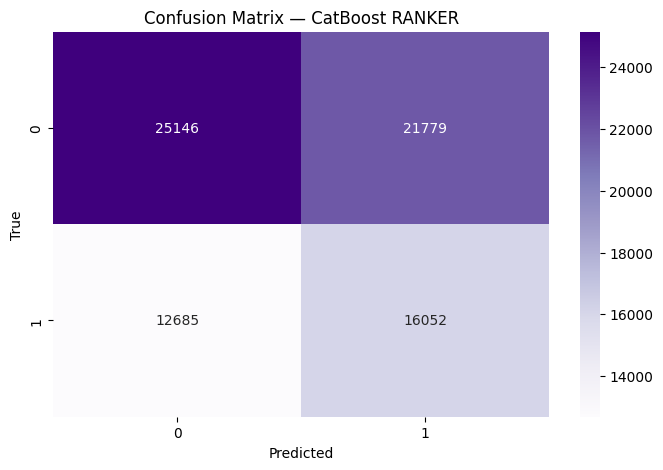

In [33]:
# %% 
# 15. RANKER score as a binary predictor (>10%)

rank_scores_test = ranker_model.predict(rank_test_pool)
rank_y_test = rank_test["target"].values  # important: same order as in rank_test_pool

rank_auc = roc_auc_score(rank_y_test, rank_scores_test)
print("\nRanker ROC-AUC vs binary target (>10%):", rank_auc)

# threshold — median score (purely for illustration)
rank_pred = (rank_scores_test >= np.median(rank_scores_test)).astype(int)

print("\nRanker classification report (threshold=median):")
print(classification_report(rank_y_test, rank_pred))

cm_rank = confusion_matrix(rank_y_test, rank_pred)
sns.heatmap(cm_rank, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix — CatBoost RANKER")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

=== Базовий опис 6-місячної дохідності ===
count    230546.000000
mean          0.077499
std           0.396871
min          -0.708479
1%           -0.617974
5%           -0.438004
50%           0.026946
95%           0.754231
99%           1.675152
max           2.776197
Name: return_6m, dtype: float64

=== Середня дохідність за класами таргету (>10% росту) ===
                   mean    median       std   count
target                                             
return <= 10% -0.138899 -0.097296  0.179943  141454
return > 10%   0.421081  0.280868  0.404693   89092


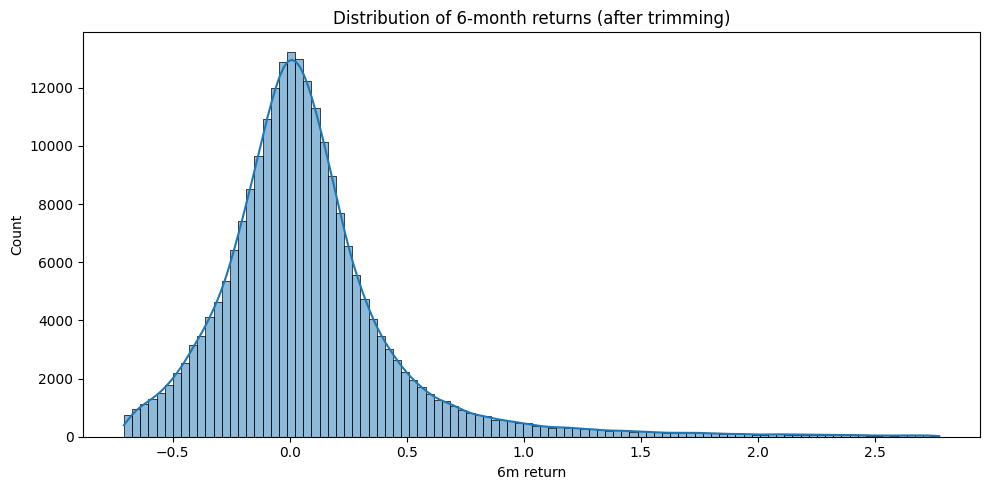

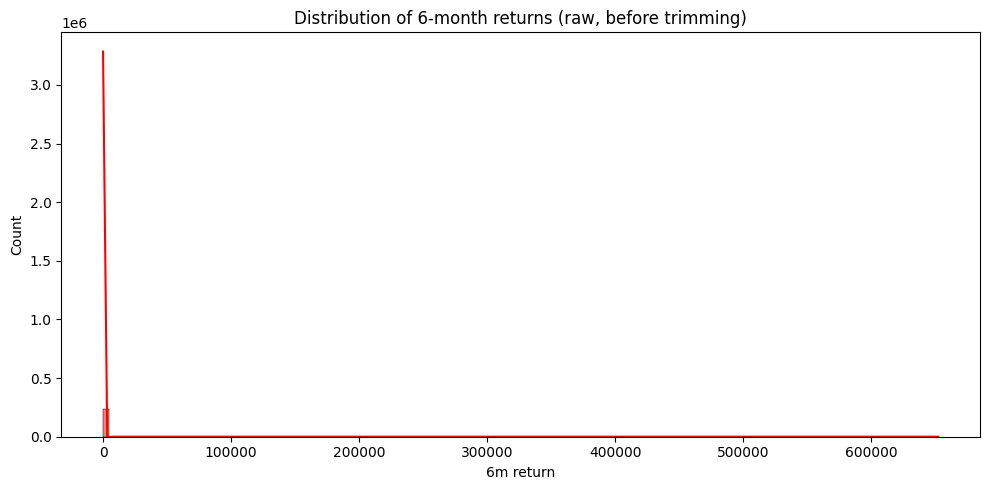

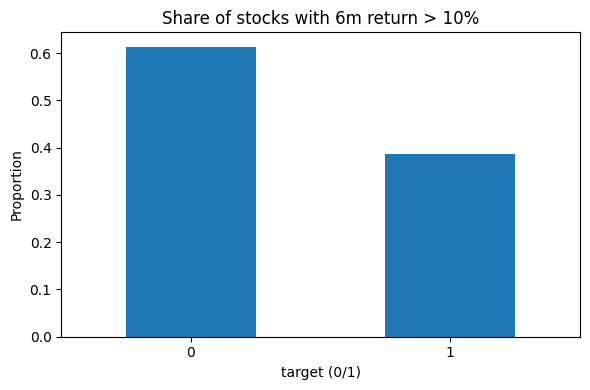

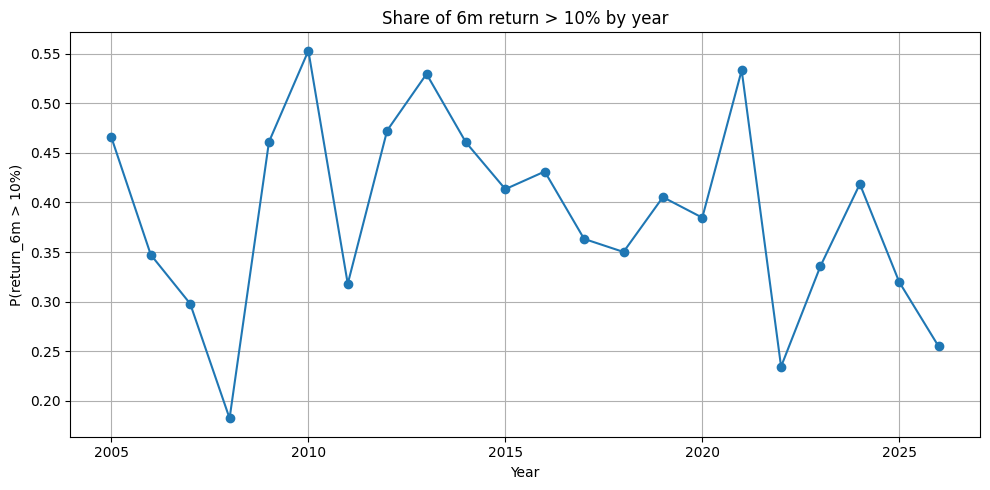

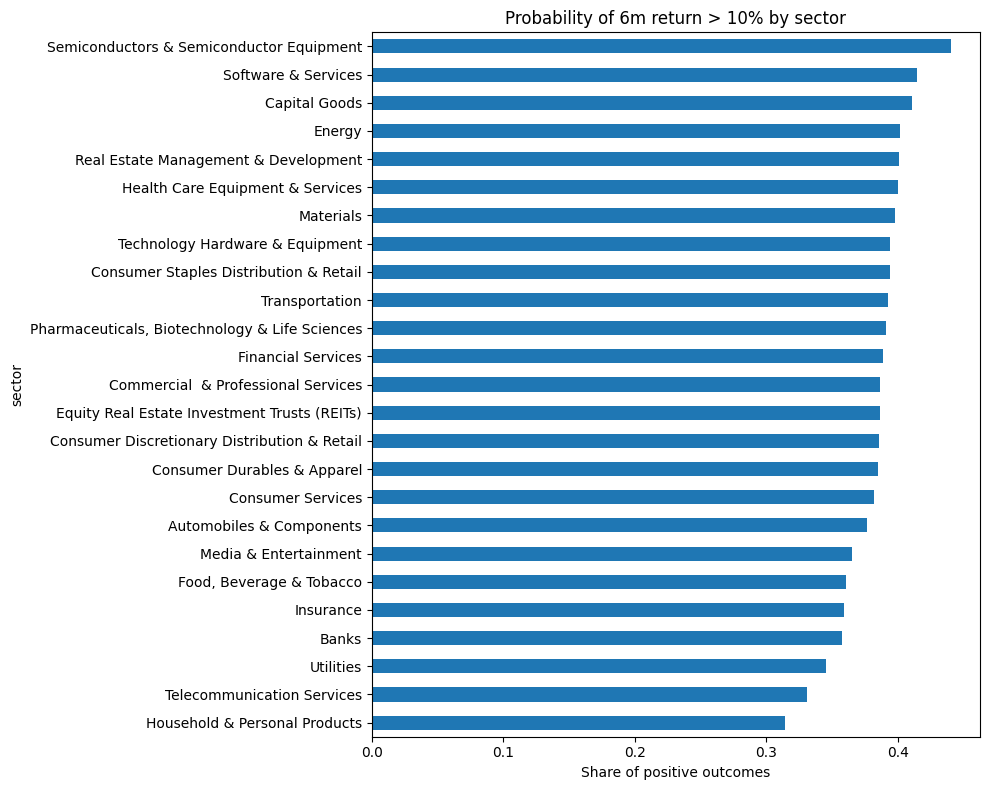

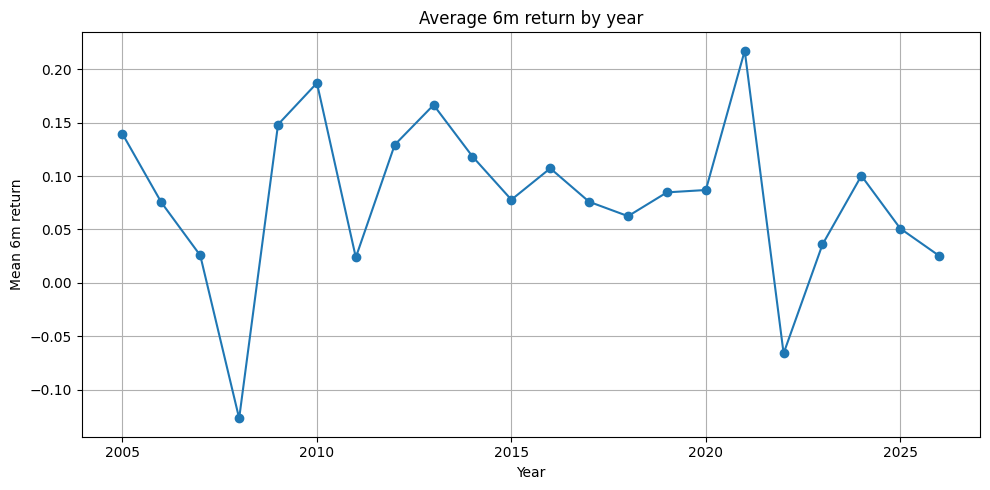

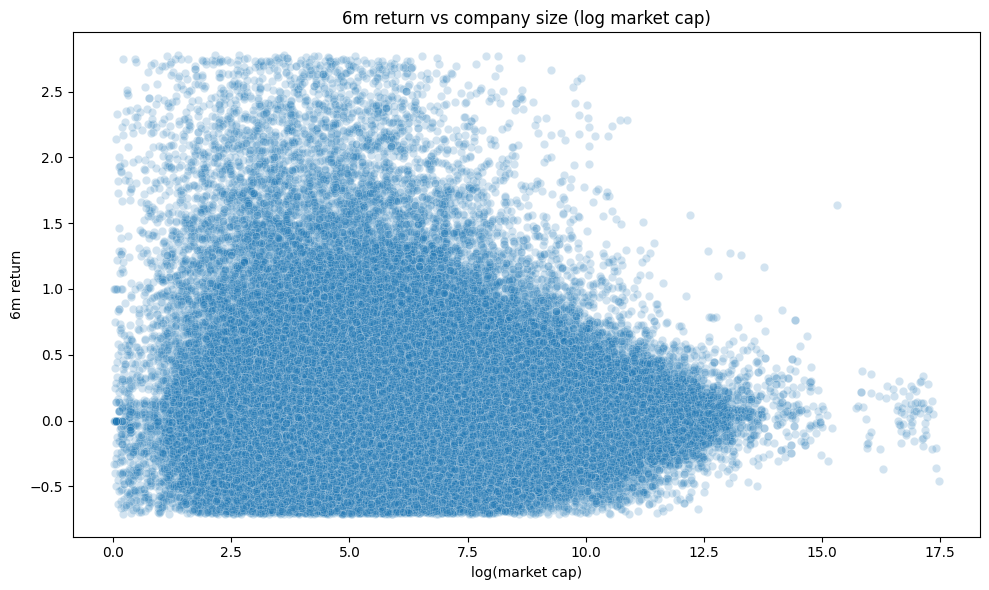

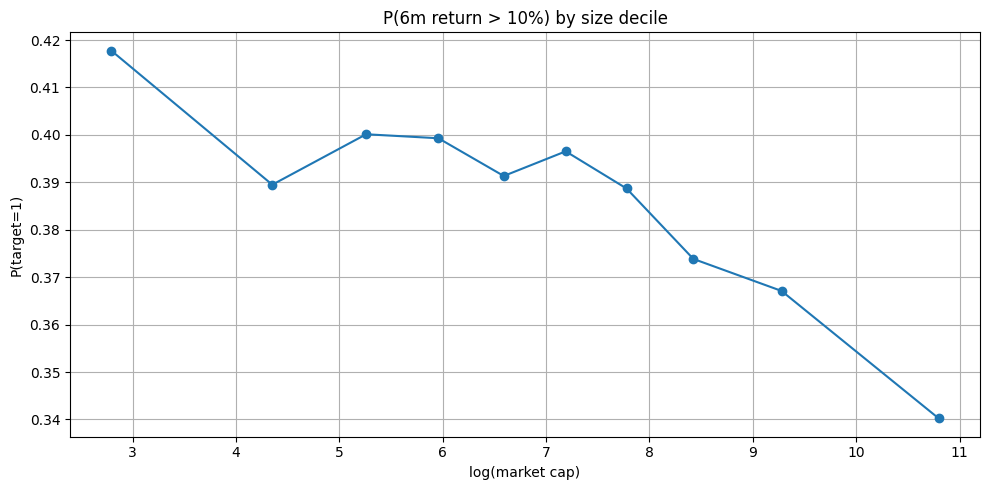

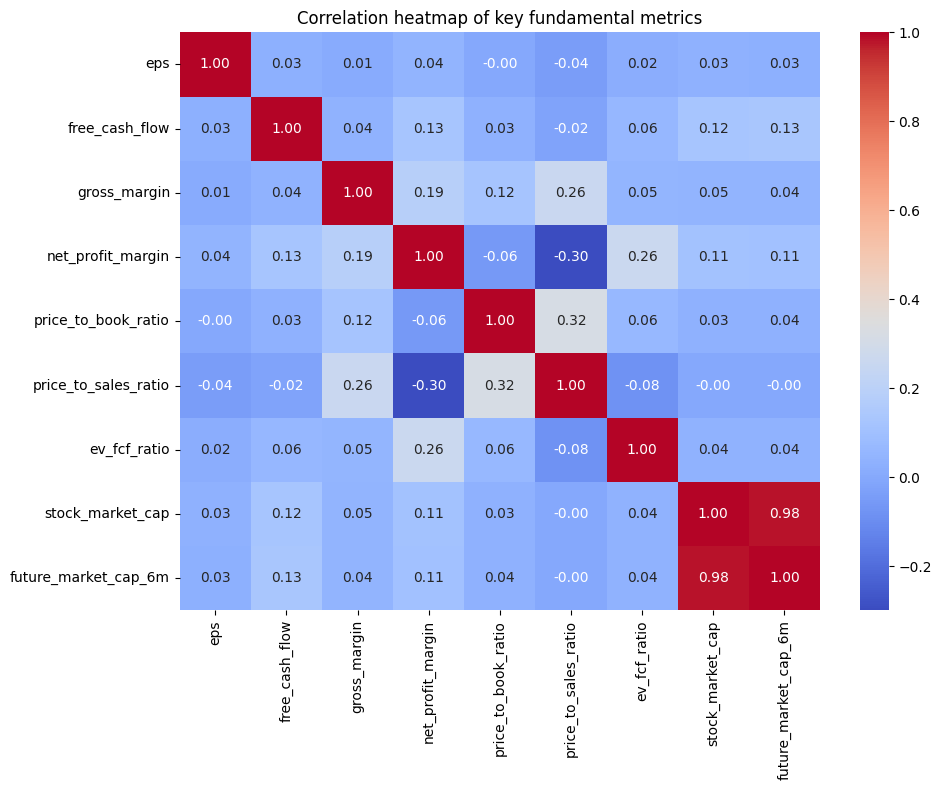

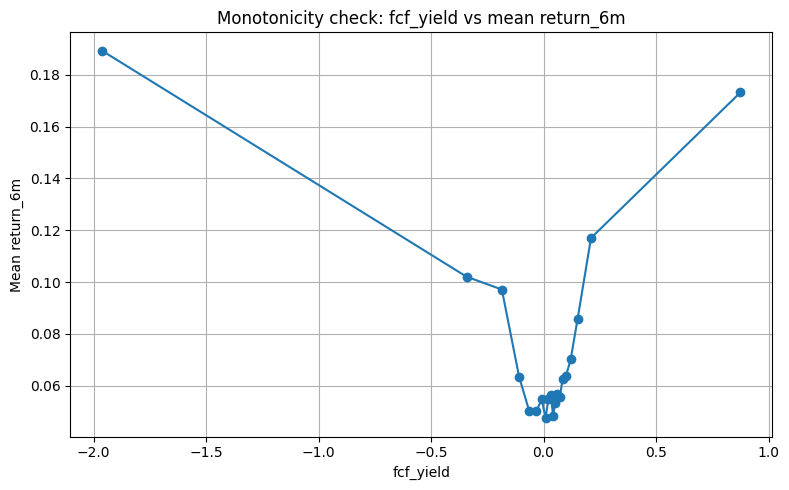

               x         y  count
bucket                           
0      -1.961928  0.189236  11267
1      -0.342058  0.102059  11267
2      -0.185225  0.097119  11266
3      -0.108825  0.063560  11267
4      -0.063077  0.050077  11267


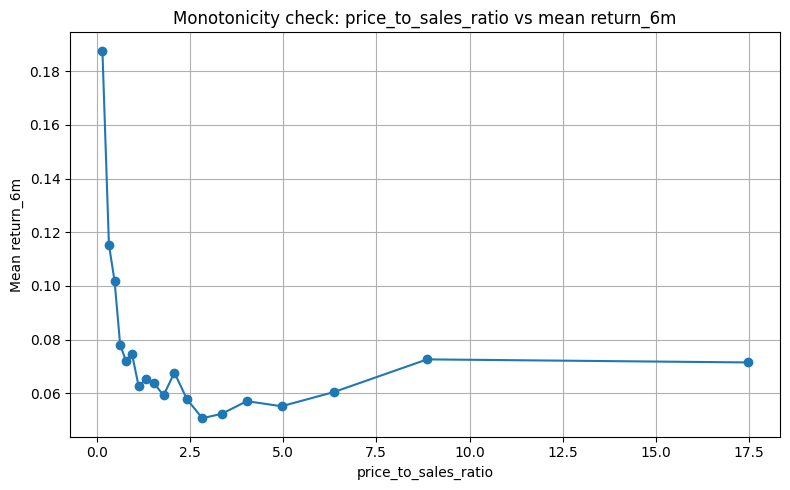

               x         y  count
bucket                           
0       0.156925  0.187614  10440
1       0.331134  0.115410  10442
2       0.482658  0.101864  10439
3       0.632595  0.078125  10438
4       0.787578  0.072018  10440


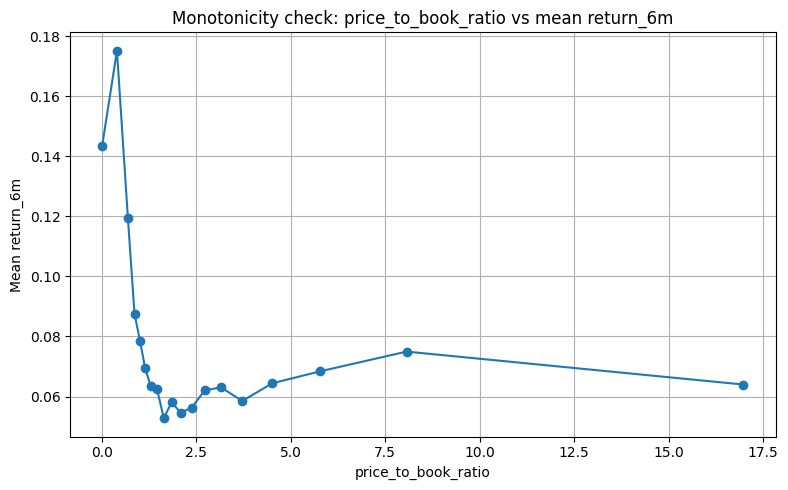

               x         y  count
bucket                           
0       0.007054  0.143570  11437
1       0.397002  0.175137  11405
2       0.686848  0.119435  11697
3       0.861947  0.087546  11163
4       1.005174  0.078651  11513


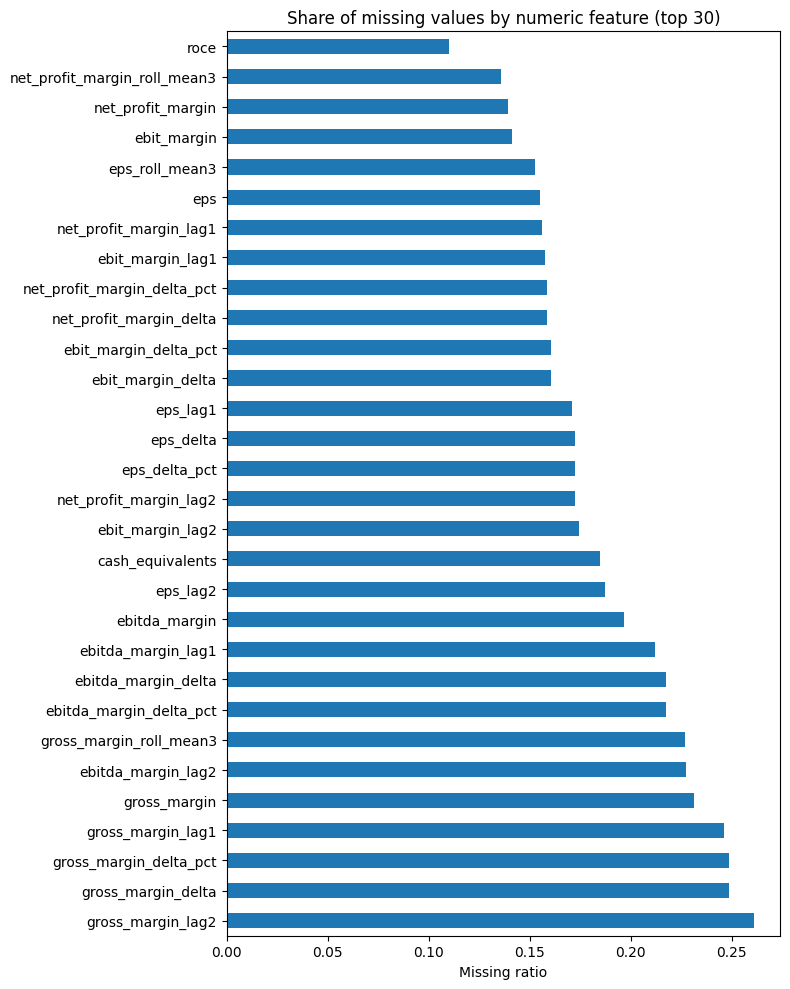


Top 15 features by missing ratio:
gross_margin_lag2          0.260790
gross_margin_delta         0.248710
gross_margin_delta_pct     0.248710
gross_margin_lag1          0.245977
gross_margin               0.231125
ebitda_margin_lag2         0.227074
gross_margin_roll_mean3    0.226818
ebitda_margin_delta_pct    0.217462
ebitda_margin_delta        0.217462
ebitda_margin_lag1         0.211919
ebitda_margin              0.196807
eps_lag2                   0.187173
cash_equivalents           0.184549
ebit_margin_lag2           0.174191
net_profit_margin_lag2     0.172612
dtype: float64


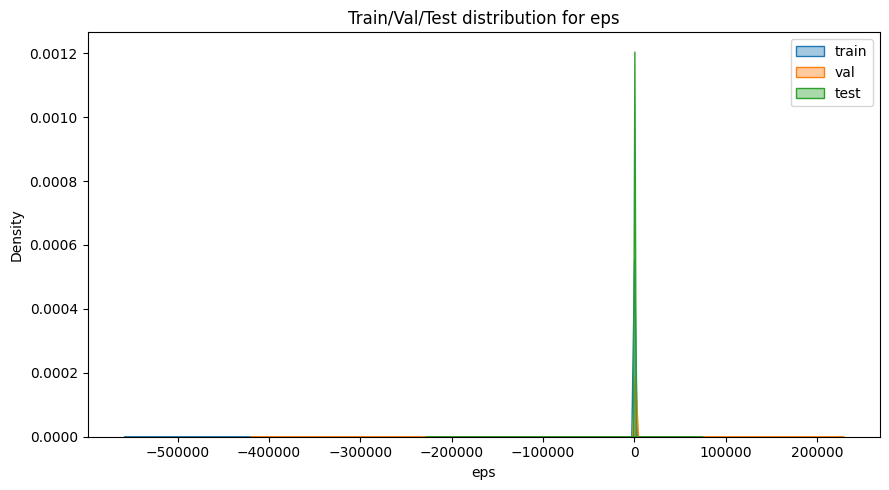

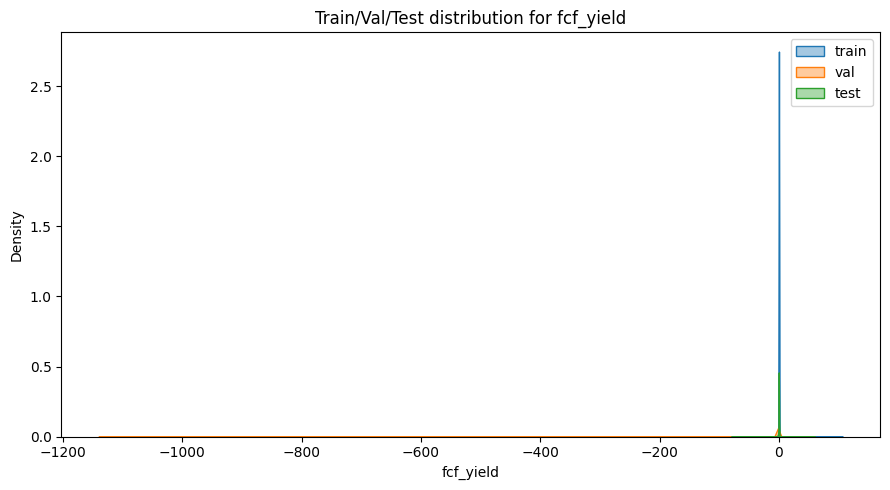

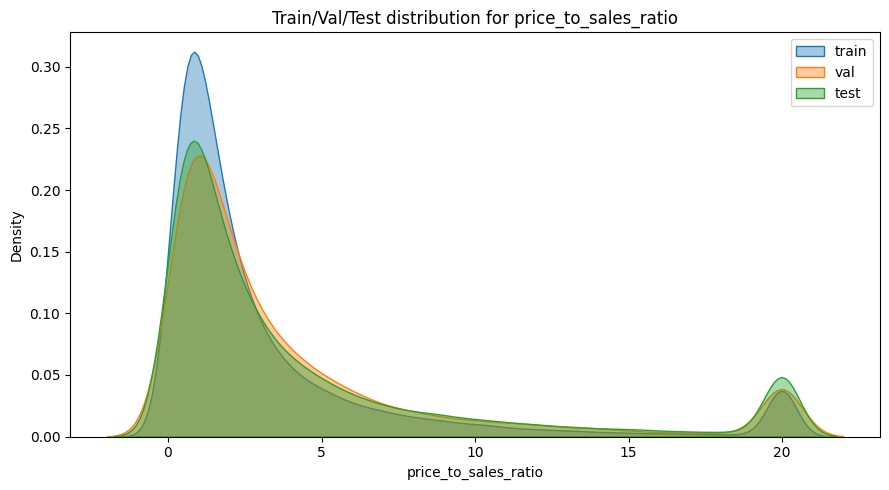

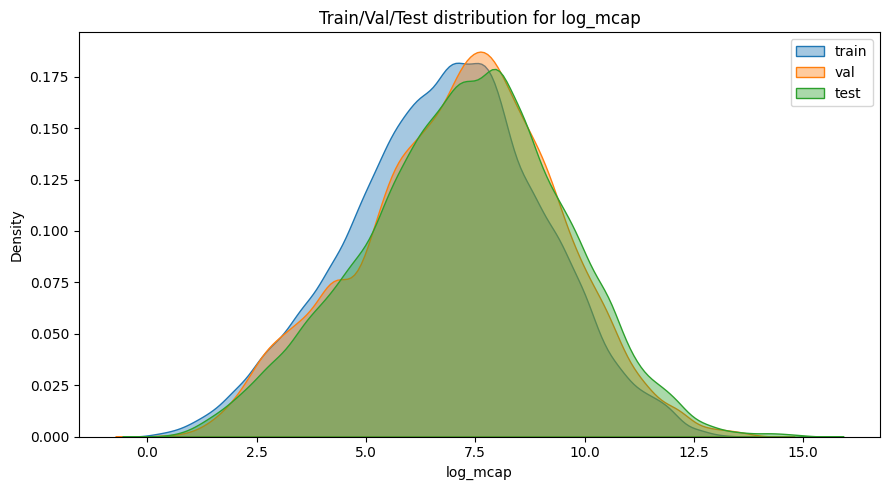


=== Summary table for report ===
                                  0
n_rows_total          230546.000000
n_train                85843.000000
n_val                  32109.000000
n_test                 75662.000000
share_target_1_total       0.386439
share_target_1_train       0.419254
share_target_1_val         0.334891
share_target_1_test        0.379808
return_6m_mean             0.077499
return_6m_std              0.396871


In [34]:
# %%
# =========================================
# EDA: загальний огляд даних та структури
# =========================================

plt.rcParams["figure.figsize"] = (9, 5)

# ---- 1. Базові описові статистики ----

print("=== Базовий опис 6-місячної дохідності ===")
print(df["return_6m"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

print("\n=== Середня дохідність за класами таргету (>10% росту) ===")
print(
    df.groupby("target")["return_6m"]
      .agg(["mean", "median", "std", "count"])
      .rename(index={0: "return <= 10%", 1: "return > 10%"})
)

# %%
# =========================================
# 15.1. Розподіл 6-місячної дохідності
# =========================================

# гістограма після триммінгу
plt.figure(figsize=(10, 5))
sns.histplot(df["return_6m"], bins=100, kde=True)
plt.title("Distribution of 6-month returns (after trimming)")
plt.xlabel("6m return")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# порівняння з «сирими» даними до триммінгу
raw = pd.read_csv("export.csv")
raw = raw[(raw["stock_market_cap"] > 0) & (raw["future_market_cap_6m"] > 0)]
raw["return_6m"] = raw["future_market_cap_6m"] / raw["stock_market_cap"] - 1

plt.figure(figsize=(10, 5))
sns.histplot(raw["return_6m"], bins=150, kde=True, color="red")
plt.title("Distribution of 6-month returns (raw, before trimming)")
plt.xlabel("6m return")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# %%
# =========================================
# 15.2. Розподіл таргету в цілому і по роках
# =========================================

plt.figure(figsize=(6, 4))
df["target"].value_counts(normalize=True).sort_index().plot(kind="bar")
plt.title("Share of stocks with 6m return > 10%")
plt.xlabel("target (0/1)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

if "target_date" in df.columns:
    tmp = df.copy()
    tmp["year"] = tmp["target_date"].dt.year
    yearly_target = (
        tmp.groupby("year")["target"]
        .mean()
        .dropna()
    )
    plt.figure(figsize=(10, 5))
    yearly_target.plot(marker="o")
    plt.title("Share of 6m return > 10% by year")
    plt.xlabel("Year")
    plt.ylabel("P(return_6m > 10%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# %%
# =========================================
# 15.3. Sector uplift — ймовірність росту по секторах
# =========================================

if "sector" in df.columns:
    sector_stats = (
        df.groupby("sector")["target"]
          .mean()
          .sort_values()
          .dropna()
    )

    plt.figure(figsize=(10, 8))
    sector_stats.plot(kind="barh")
    plt.title("Probability of 6m return > 10% by sector")
    plt.xlabel("Share of positive outcomes")
    plt.tight_layout()
    plt.show()

# %%
# =========================================
# 15.4. Сезонність / часова динаміка середньої дохідності
# =========================================

if "target_date" in df.columns:
    annual_ret = (
        df.groupby(df["target_date"].dt.year)["return_6m"]
          .mean()
          .dropna()
    )

    plt.figure(figsize=(10, 5))
    annual_ret.plot(marker="o")
    plt.title("Average 6m return by year")
    plt.xlabel("Year")
    plt.ylabel("Mean 6m return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# %%
# =========================================
# 15.5. Вплив розміру компанії (капіталізація)
# =========================================

if "log_mcap" in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df["log_mcap"],
        y=df["return_6m"],
        alpha=0.2
    )
    plt.title("6m return vs company size (log market cap)")
    plt.xlabel("log(market cap)")
    plt.ylabel("6m return")
    plt.tight_layout()
    plt.show()

# можна також подивитися, як змінюється частка успішних кейсів по квантилях розміру
if "log_mcap" in df.columns:
    tmp = df[["log_mcap", "target"]].dropna()
    tmp["size_bucket"] = pd.qcut(tmp["log_mcap"], 10, labels=False)

    size_stats = tmp.groupby("size_bucket")["target"].mean()
    size_x = tmp.groupby("size_bucket")["log_mcap"].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(size_x, size_stats, marker="o")
    plt.title("P(6m return > 10%) by size decile")
    plt.xlabel("log(market cap)")
    plt.ylabel("P(target=1)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# %%
# =========================================
# 15.6. Кореляції ключових фундаментальних ознак
# =========================================

corr_cols = [
    "eps", "free_cash_flow", "gross_margin", "net_profit_margin",
    "price_to_book_ratio", "price_to_sales_ratio", "ev_fcf_ratio",
    "stock_market_cap", "future_market_cap_6m"
]
corr_cols = [c for c in corr_cols if c in df.columns]

if len(corr_cols) >= 2:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[corr_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation heatmap of key fundamental metrics")
    plt.tight_layout()
    plt.show()

# %%
# =========================================
# 15.7. Перевірка «монотонності» для важливих фінансових фіч
# =========================================

def monotonicity_plot(feature, target_col="return_6m", n_bins=20):
    """Проста перевірка: як змінюється середня дохідність по квантилях ознаки."""
    if feature not in df.columns:
        print(f"[skip] {feature} відсутня у датафреймі")
        return

    tmp = df[[feature, target_col]].dropna()
    if tmp.empty:
        print(f"[skip] {feature}: немає даних після dropna()")
        return

    tmp["bucket"] = pd.qcut(tmp[feature], n_bins, labels=False, duplicates="drop")
    grouped = tmp.groupby("bucket").agg(
        x=(feature, "mean"),
        y=(target_col, "mean"),
        count=(target_col, "size"),
    )

    plt.figure(figsize=(8, 5))
    plt.plot(grouped["x"], grouped["y"], marker="o")
    plt.title(f"Monotonicity check: {feature} vs mean {target_col}")
    plt.xlabel(feature)
    plt.ylabel(f"Mean {target_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(grouped.head())

for feat in ["fcf_yield", "price_to_sales_ratio", "price_to_book_ratio"]:
    monotonicity_plot(feat)

# %%
# =========================================
# 15.8. Пропуски за ознаками (missing values)
# =========================================

missing = df[num_features].isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 10))
missing.head(30).plot(kind="barh")
plt.title("Share of missing values by numeric feature (top 30)")
plt.xlabel("Missing ratio")
plt.tight_layout()
plt.show()

print("\nTop 15 features by missing ratio:")
print(missing.head(15))

# %%
# =========================================
# 15.9. Стабільність розподілу між train / val / test
# =========================================

def compare_dist(feature):
    """Порівняння розподілів однієї ознаки у train/val/test."""
    if feature not in df.columns:
        print(f"[skip] {feature} відсутня у датафреймі")
        return

    plt.figure(figsize=(9, 5))
    sns.kdeplot(train[feature].dropna(), label="train", fill=True, alpha=0.4)
    sns.kdeplot(val[feature].dropna(), label="val", fill=True, alpha=0.4)
    sns.kdeplot(test[feature].dropna(), label="test", fill=True, alpha=0.4)
    plt.title(f"Train/Val/Test distribution for {feature}")
    plt.xlabel(feature)
    plt.legend()
    plt.tight_layout()
    plt.show()

for feat in ["eps", "fcf_yield", "price_to_sales_ratio", "log_mcap"]:
    if feat in df.columns:
        compare_dist(feat)

# %%
# =========================================
# 15.10. Таблиця для тексту в дипломі
# =========================================

# Короткий зведений опис, який зручно вставляти в звіт як таблицю
summary_table = pd.DataFrame({
    "n_rows_total": [len(df)],
    "n_train": [len(train)],
    "n_val": [len(val)],
    "n_test": [len(test)],
    "share_target_1_total": [df["target"].mean()],
    "share_target_1_train": [train["target"].mean()],
    "share_target_1_val": [val["target"].mean()],
    "share_target_1_test": [test["target"].mean()],
    "return_6m_mean": [df["return_6m"].mean()],
    "return_6m_std": [df["return_6m"].std()],
})

print("\n=== Summary table for report ===")
print(summary_table.T)

In [35]:
# =========================================
# 15.11. Sector-wise performance (Classifier)
# =========================================

sector_auc = []

for sector, gdf in test.groupby("sector"):
    if gdf["target"].nunique() < 2:
        continue

    pool = Pool(gdf[all_features], cat_features=cat_cols)
    proba = clf_model.predict_proba(pool)[:, 1]
    auc = roc_auc_score(gdf["target"], proba)

    sector_auc.append({
        "sector": sector,
        "n_samples": len(gdf),
        "auc": auc
    })

sector_auc_df = pd.DataFrame(sector_auc).sort_values("auc", ascending=False)
print(sector_auc_df)

                                            sector  n_samples       auc
24                                         Unknown        544  0.688612
13                   Household & Personal Products        832  0.665065
22                      Telecommunication Services        927  0.644122
11                        Food, Beverage & Tobacco       1977  0.635037
5                      Consumer Durables & Apparel       2521  0.628939
0                         Automobiles & Components       1129  0.611702
8                                           Energy       4236  0.611678
15                                       Materials       3824  0.609635
14                                       Insurance       2112  0.606602
2                                    Capital Goods       6867  0.603011
21                 Technology Hardware & Equipment       3625  0.599578
4     Consumer Discretionary Distribution & Retail       2841  0.597133
12                Health Care Equipment & Services       4919  0

In [36]:
# %% 
# 16. NDCG@k by quarter (same groups for both models)

def ndcg_at_k(y_true_sorted, k):
    y = np.array(y_true_sorted)[:k]
    gains = (2 ** y - 1)
    discounts = 1.0 / np.log2(np.arange(2, len(y) + 2))
    dcg = np.sum(gains * discounts)

    ideal = np.sort(y)[::-1]
    idcg = np.sum((2 ** ideal - 1) / np.log2(np.arange(2, len(ideal) + 2)))
    if idcg == 0:
        return np.nan
    return dcg / idcg

def compute_group_ndcg(frame, scores, k_list=(5, 10, 20)):
    df_tmp = frame.copy()
    df_tmp["score"] = scores
    res = {k: [] for k in k_list}

    for _, gdf in df_tmp.groupby("group_id"):
        gdf = gdf.sort_values("score", ascending=False)
        y = gdf["target"].values
        for k in k_list:
            res[k].append(ndcg_at_k(y, k))

    return {k: np.nanmean(v) for k, v in res.items()}

# for the ranker we use rank_test / rank_scores_test
ndcg_ranker = compute_group_ndcg(rank_test, rank_scores_test, k_list=(5, 10, 20))

# for the classifier - the same groups; re-sort the test under group_id
clf_test_for_ndcg = test.sort_values(["group_id", "ttm_date", "stock_name"]).reset_index(drop=True)
proba_test_clf_sorted = clf_model.predict_proba(
    Pool(clf_test_for_ndcg[all_features], cat_features=cat_cols)
)[:, 1]

ndcg_clf = compute_group_ndcg(clf_test_for_ndcg, proba_test_clf_sorted, k_list=(5, 10, 20))

print("\nNDCG@k (test, mean over quarters):")
print("Ranker:", ndcg_ranker)
print("Classifier:", ndcg_clf)


NDCG@k (test, mean over quarters):
Ranker: {5: np.float64(0.8239619829858249), 10: np.float64(0.8071608121669683), 20: np.float64(0.8053730899316118)}
Classifier: {5: np.float64(0.871352071662086), 10: np.float64(0.8445006433440824), 20: np.float64(0.8401184276978414)}


In [37]:
# =========================================
# 16.1. NDCG@10 by year
# =========================================

def ndcg_by_year(frame, scores, k=10):
    df_tmp = frame.copy()
    df_tmp["score"] = scores
    df_tmp["year"] = df_tmp["ttm_date"].dt.year

    res = []

    for year, ydf in df_tmp.groupby("year"):
        vals = []
        for _, gdf in ydf.groupby("group_id"):
            gdf = gdf.sort_values("score", ascending=False)
            vals.append(ndcg_at_k(gdf["target"].values, k))
        res.append({"year": year, "ndcg@10": np.nanmean(vals)})

    return pd.DataFrame(res)

ndcg_year_clf = ndcg_by_year(
    clf_test_for_ndcg,
    proba_test_clf_sorted,
    k=10
)

ndcg_year_ranker = ndcg_by_year(
    rank_test,
    rank_scores_test,
    k=10
)

print("NDCG@10 by year — Classifier")
print(ndcg_year_clf)

print("NDCG@10 by year — Ranker")
print(ndcg_year_ranker)

NDCG@10 by year — Classifier
   year   ndcg@10
0  2020  0.966104
1  2021  0.804931
2  2022  0.820796
3  2023  0.831455
4  2024  0.832285
5  2025  0.811434
NDCG@10 by year — Ranker
   year   ndcg@10
0  2020  0.939160
1  2021  0.837455
2  2022  0.760835
3  2023  0.733732
4  2024  0.755045
5  2025  0.816738


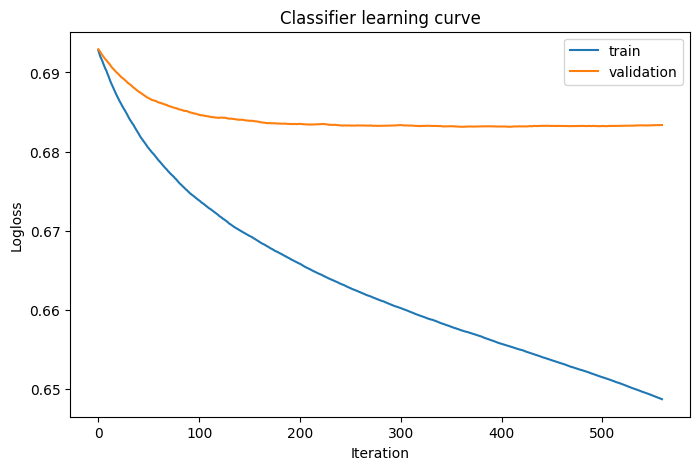

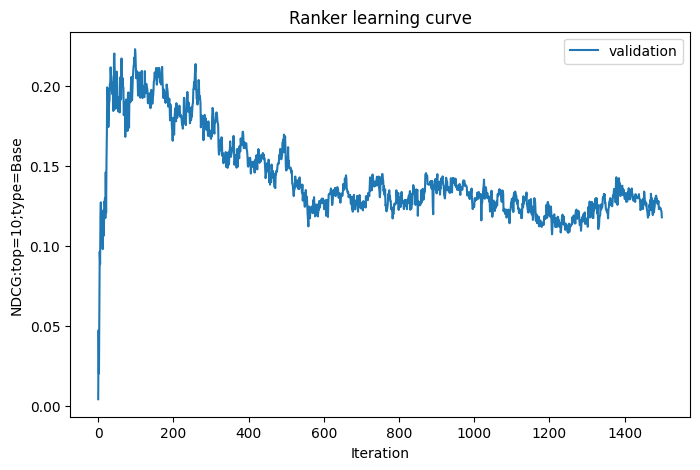

In [38]:
# %%
# 17. Learning curves (как были)

def plot_learning_curves(evals_result, title):
    if evals_result is None or len(evals_result) == 0:
        print(f"[{title}] evals_result is empty, nothing to plot")
        return

    learn_metrics = evals_result.get("learn", {})
    valid_metrics = evals_result.get("validation", {})

    # no metrics at all → nothing to plot
    if len(learn_metrics) == 0 and len(valid_metrics) == 0:
        print(f"[{title}] both learn and validation metrics are empty")
        return

    # choose metric name
    if len(valid_metrics) > 0:
        metric_name = list(valid_metrics.keys())[0]
    else:
        metric_name = list(learn_metrics.keys())[0]

    plt.figure(figsize=(8, 5))

    if metric_name in learn_metrics:
        plt.plot(learn_metrics[metric_name], label="train")

    if metric_name in valid_metrics:
        plt.plot(valid_metrics[metric_name], label="validation")

    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_learning_curves(clf_evals_result, "Classifier learning curve")
plot_learning_curves(rank_evals_result, "Ranker learning curve")

In [39]:
# %%
# 18. Summary comparison of models

summary = pd.DataFrame({
    "model": ["classifier", "ranker", "logreg_baseline"],
    "test_auc": [clf_auc, rank_auc, auc_lr],
    "ndcg@5":  [ndcg_clf[5], ndcg_ranker[5], np.nan],
    "ndcg@10": [ndcg_clf[10], ndcg_ranker[10], np.nan],
    "ndcg@20": [ndcg_clf[20], ndcg_ranker[20], np.nan],
})

print("\nSummary comparison:")
print(summary)


Summary comparison:
             model  test_auc    ndcg@5   ndcg@10   ndcg@20
0       classifier  0.585170  0.871352  0.844501  0.840118
1           ranker  0.567008  0.823962  0.807161  0.805373
2  logreg_baseline  0.535065       NaN       NaN       NaN



Running SHAP analysis on a sample of test data (classifier)...


/Users/gregory/Documents/GO IT/Диплом/goit-major/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


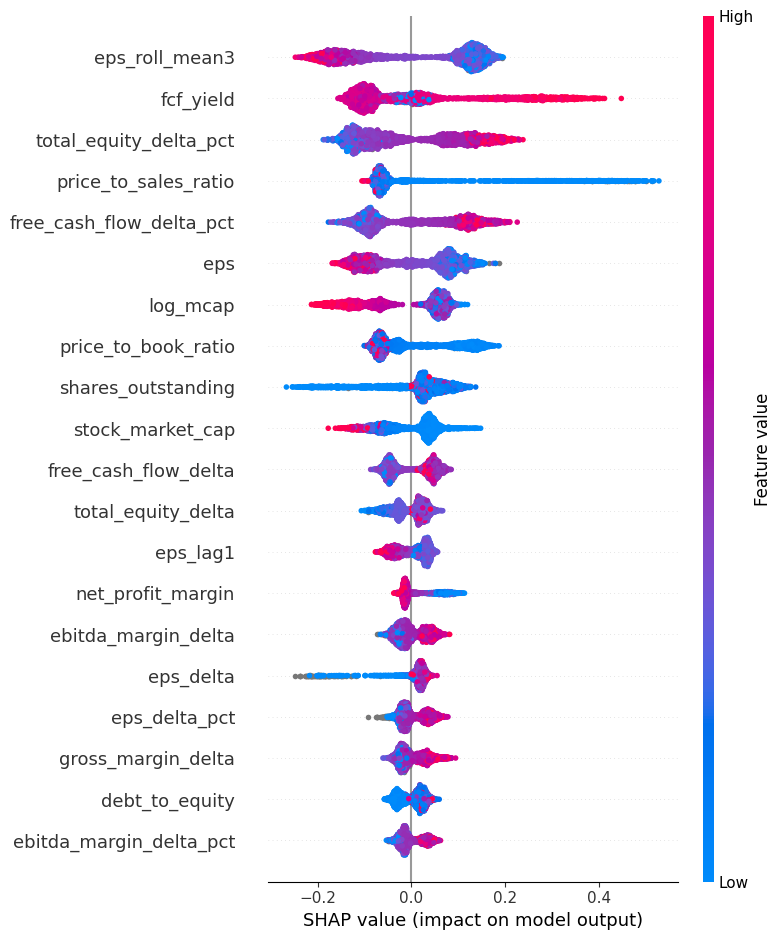

In [40]:
# %%
# =========================================
# 19. SHAP analysis (for CLASSIFIER)
# =========================================

try:
    import shap

    print("\nRunning SHAP analysis on a sample of test data (classifier)...")
    shap.initjs()

    sample_size = min(3000, len(X_test))
    X_sample = X_test.sample(sample_size, random_state=42)

    sample_pool = Pool(X_sample, cat_features=cat_cols)
    shap_values = clf_model.get_feature_importance(sample_pool, type="ShapValues")

    # убираем base value
    if shap_values.ndim == 3:
        shap_values_ = shap_values[:, 1, :-1]
    else:
        shap_values_ = shap_values[:, :-1]

    shap.summary_plot(shap_values_, X_sample, show=False)
    plt.tight_layout()
    plt.show()

except ImportError:
    print("SHAP is not installed, skipping SHAP analysis.")
except Exception as e:
    print("SHAP analysis failed:", e)